# Course 6 - PyTorch implementation of logistic regression and feed-forward neural networks

## Import librairies and dataset

In [ ]:
#!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy gensim

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk import word_tokenize, sent_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import eli5
import numpy as np

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

/home/gcortal/anaconda3/envs/epita/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("gustavecortal/DreamBank-annotated")
df = dataset["train"].to_pandas()
df = df.sample(frac = 1)
df["report"] = df["report"].astype(str)
df = df.query("emotion == 'CO D' or emotion == 'AN D' or emotion == 'SD D' or emotion == 'AP D' or emotion == 'HA D'")[["report", "emotion"]]
df.head()

,report,emotion
2946,"I'm in a sort of playground area, only it's in...",AN D
160,There's a kind of war or rebellion going on at...,AP D
1102,American has purchased reclaimed land from the...,CO D
27512,I'm in a dimly lit room that holds the spirits...,AP D
26516,Driving home from work late. There was a side...,CO D


## Preprocessing and visualization

Convert code to emotion class according to the annotation guideline : https://dreams.ucsc.edu/Coding/emotions.html

In [3]:
def to_emotion_class(emotion):
    
    if emotion == "AP D":
        return "fear"
    elif emotion == "CO D":
        return "confusion"
    elif emotion == "SD D":
        return "sadness"
    elif emotion == "AN D":
        return "anger"
    else:
        return "happiness"

df["emotion"] = df["emotion"].apply(lambda x: to_emotion_class(x))
df["report"] = df["report"].apply(lambda x: x.lower()) # simple preprocessing (lowercase only)
df.head()

,report,emotion
2946,"i'm in a sort of playground area, only it's in...",anger
160,there's a kind of war or rebellion going on at...,fear
1102,american has purchased reclaimed land from the...,confusion
27512,i'm in a dimly lit room that holds the spirits...,fear
26516,driving home from work late. there was a side...,confusion


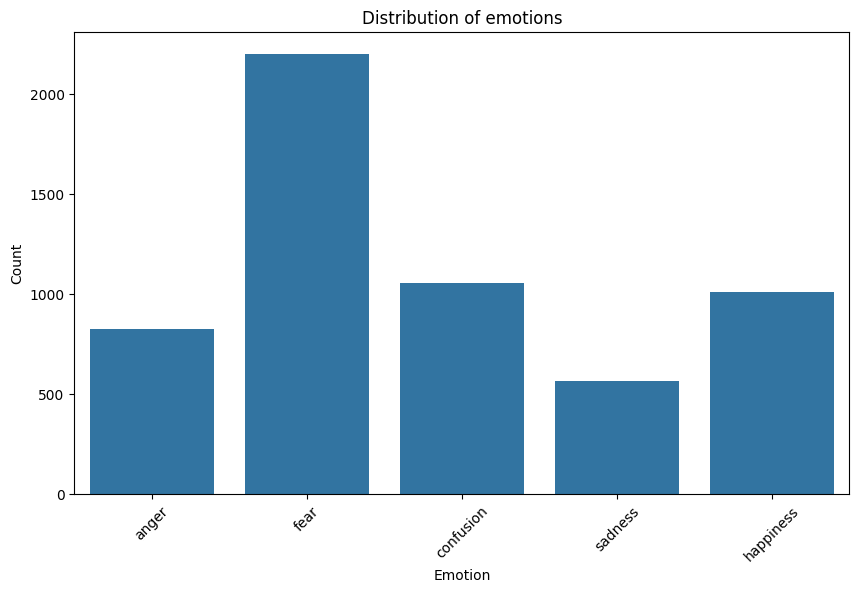

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)

plt.title('Distribution of emotions') 
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

## Training Word2vec

In [5]:
X_list = list(df["report"])
X_strings = " ".join(X_list)
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

In [6]:
model = Word2Vec(sentences=X_sents, vector_size=50, window=5, min_count=5, workers=4)
#model = Word2Vec(sentences=X_sents, vector_size=100, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [7]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['war']
sims = wv.most_similar('school', topn=10)
sims

[('college', 0.8354191184043884),
 ('university', 0.7460114359855652),
 ('westport', 0.6804368495941162),
 ('junior', 0.6769436001777649),
 ('church', 0.6533600687980652),
 ('brimson', 0.6523252129554749),
 ('city', 0.6390878558158875),
 ('restaurant', 0.6358777284622192),
 ('staying', 0.632278561592102),
 ('meeting', 0.6287503242492676)]

### Load pretrained Word2vec models

In [71]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [72]:
pretrained_wv = gensim.downloader.load('glove-twitter-100')
print(pretrained_wv.most_similar('kevin'))
print(pretrained_wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1))

[('chris', 0.8121618032455444), ('james', 0.7955256700515747), ('joe', 0.7932372689247131), ('mike', 0.7850410342216492), ('anthony', 0.7785152792930603), ('ryan', 0.7772720456123352), ('josh', 0.7681067585945129), ('danny', 0.7669281959533691), ('martin', 0.7561131119728088), ('tony', 0.7466763854026794)]
[('queen', 0.7052316069602966)]


In [73]:
pretrained_wv

### Embed documents using Word2vec

In [8]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [9]:
document_vector("hello i'm gustave", wv)

array([-0.1590178 ,  1.0080061 , -1.7891803 ,  0.39875498,  0.51553303,
       -0.13202308,  0.07602569, -1.2106122 , -0.7621236 ,  0.41061005,
        0.19461997, -0.27766737,  0.33896756, -0.30336887, -1.5025657 ,
       -0.1438276 , -0.03450378, -0.40640453, -2.4633534 , -0.0809966 ,
        0.8975706 ,  0.11168957, -0.43253085, -1.0144707 , -0.09317059,
       -1.4372205 ,  0.4182998 ,  0.92039007, -1.050299  ,  0.43063155,
        0.42847812, -0.8412657 , -0.20338853,  0.96106434, -0.39079297,
       -1.403957  , -0.17974328,  0.5140849 , -0.38006935, -0.6934406 ,
       -0.31601128,  0.10226524,  0.03522162,  0.7500138 , -0.31057632,
       -0.7997578 , -0.67227286, -0.855439  , -1.4975137 ,  0.8867076 ],
      dtype=float32)

In [37]:
document_vector("hello i'm gustave", pretrained_wv)

array([ 1.06234513e-02,  3.72975022e-02, -8.76264870e-02,  1.91324979e-01,
       -3.21467996e-01, -1.96269993e-02,  8.25392380e-02, -1.26881510e-01,
        2.30521262e-01,  3.14925052e-02, -3.52858752e-02, -3.11605006e-01,
       -3.27135992e+00, -9.83899981e-02, -1.58699974e-02,  1.59127504e-01,
        8.28345045e-02,  7.97371566e-03, -3.28304976e-01, -1.46375000e-01,
        8.91950056e-02, -6.60991013e-01, -1.90470219e-02, -4.90215003e-01,
        1.10356249e-01, -5.24932504e-01,  1.25850271e-03,  2.64232486e-01,
        3.58432502e-01, -5.27852535e-01, -1.72123998e-01,  1.99335009e-01,
       -3.29671502e-01, -1.07807502e-01, -7.35374987e-02,  4.31460068e-02,
       -1.23240992e-01,  1.02078997e-01,  4.95415002e-01,  2.15272516e-01,
       -8.49732518e-01, -8.40062499e-02, -1.17344998e-01, -1.06314242e-01,
       -1.62129961e-02,  1.71487495e-01, -6.80849999e-02, -5.87677538e-01,
       -2.82429934e-01,  2.15227500e-01, -1.54695019e-01,  5.20460531e-02,
       -2.09272504e-01, -

## Training and test sets for Word2vec

In [10]:
X = df['report']
y = df['emotion']

X = np.array([document_vector(text, wv) for text in X])
#X = np.array([document_vector(text, pretrained_wv) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (4520, 50)


## Training and test sets for tf-idf

In [7]:
X = df['report']
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Tokenization functions

In [11]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

def gpt_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

## Training: Logistic regression

In [12]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [13]:
label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

In [14]:
integer_encoded

array([0, 2, 1, ..., 2, 4, 2])

In [15]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F

class LogisticRegressionModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(vocab_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = LogisticRegressionModel(vocab_size, num_classes)
#model = MultiLayerPerceptron2(vocab_size, 10, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.AdamW(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

LogisticRegressionModel(
  (linear): Linear(in_features=50, out_features=5, bias=True)
)
Epoch [1/20], Loss: 1.5592
Precision: 0.1824, Recall: 0.3673, F1 Score: 0.2112
Epoch [2/20], Loss: 1.4708
Precision: 0.2500, Recall: 0.3681, F1 Score: 0.2224
Epoch [3/20], Loss: 1.4699
Precision: 0.2886, Recall: 0.3726, F1 Score: 0.2304
Epoch [4/20], Loss: 1.4704
Precision: 0.3427, Recall: 0.3779, F1 Score: 0.2479
Epoch [5/20], Loss: 1.4821
Precision: 0.3620, Recall: 0.3805, F1 Score: 0.2400
Epoch [6/20], Loss: 1.4935
Precision: 0.3210, Recall: 0.3770, F1 Score: 0.2826
Epoch [7/20], Loss: 1.3713
Precision: 0.3262, Recall: 0.3779, F1 Score: 0.2618
Epoch [8/20], Loss: 1.6761
Precision: 0.3373, Recall: 0.3761, F1 Score: 0.2475
Epoch [9/20], Loss: 1.3537
Precision: 0.3224, Recall: 0.3770, F1 Score: 0.2791
Epoch [10/20], Loss: 1.2750
Precision: 0.3310, Recall: 0.3814, F1 Score: 0.2821
Epoch [11/20], Loss: 1.3060
Precision: 0.3318, Recall: 0.3841, F1 Score: 0.2832
Epoch [12/20], Loss: 1.3660
Precision: 0